In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 2

# baseline: 
# exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
#            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
# exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])


exp_mc005_brier = {3: "20180428_09_11_35_dcnn_mc_f3p005_brier_150KE_lr2e02",
                   2: "20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02",
                   1: "20180426_14_45_50_dcnn_mc_f1p005_brier_150KE_lr2e02",
                   0: "20180418_15_02_36_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_brier_path = os.path.join(LOG_DIR, exp_mc005_brier[TEST_FOLD])


exp_mc01_brier_results = {0: "test_results_25imgs_fold0_04_19_17_27.dll",
                          1: "",
                          2: "",
                          3: ""}
exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])



## Load experimental data and test data set

In [3]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_mc005_brier = ExperimentHandler.load_experiment(exp_mc005_brier_path)
exper_hdl_mc005_brier = ExperimentHandler(exper_mc005_brier, use_logfile=False)
exper_hdl_mc005_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc005_brier.set_model_name("MC-dropout-brier fold-{} (p={})".format(
                                     exper_hdl_mc005_brier.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_brier.exper.model_name))


exper_mc01_brier = ExperimentHandler.load_experiment(exp_mc01_brier_path)
exper_hdl_mc01_brier = ExperimentHandler(exper_mc01_brier, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_brier.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc005_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 2
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02/stats/exper_stats.dll


  0%|          | 0/25 [00:00<?, ?it/s]

Model name MC-dropout-brier fold-2 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name MC-dropout brier fold-2 (p=0.1)
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold2/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00, 10.41it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Run model evaluation of test set

In [88]:
mc_samples = 10
sample_weights = True
store_details = True
image_range =  [9] # [0, 9, 22] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = False
# if not sample_weights & save_pred_labels => we save pred_labels & referred_pred_labels
save_filtered_umaps = False
save_pred_labels = False

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_filtered_umaps=save_filtered_umaps, save_pred_labels=save_pred_labels)


    
print("Ready")

Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-2 (p=0.1) - runID 1
INFO - Running test on 1 images with model from checkpoint 150000
Image 10-patient030 - test loss -1.049  dice(RV/Myo/LV):	ES 0.50/0.92/0.58	ED 0.82/0.87/0.81
					Hausdorff(RV/Myo/LV):	ES 24.57/17.93/16.33	ED 16.09/14.00/32.41
------------------------------------------------------------------------------------------------
Overall:	dice(RV/Myo/LV): ES 0.50 (0.00)/0.92 (0.00)/0.58 (0.00)	ED 0.82 (0.00)/0.87 (0.00)/0.81 (0.00)
Hausdorff(RV/Myo/LV):	ES 24.57 (0.00)/17.93 (0.00)/16.33 (0.00)	ED 16.09 (0.00)/14.00 (0.00)/32.41 (0.00)
INFO - generating statistics for 1 run(s). May take a while
Ready


In [86]:
mc_samples = 1
sample_weights = False
store_details = False
image_range = [9] # [10, 24] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = True
referral_threshold = 0.14
ref_positives_only = True
save_filtered_umaps = False
save_pred_labels = True

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_filtered_umaps=save_filtered_umaps, save_pred_labels=save_pred_labels)


    
print("Ready")

WARNING - Using uncertainty maps to refer pixels. Threshold 0.14
Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-2 (p=0.1) - runID 1
INFO - Running test on 1 images with model from checkpoint 150000
Slice 5 Class 2: errors 142 #true_pos 1386 #pos_labels 1372 #u-pixels 796 #pos+unc-pixels 383
Slice 5 Class 3: errors 76 #true_pos 59 #pos_labels 117 #u-pixels 796 #pos+unc-pixels 82
Ref% ES/ED 35.68/23.12 - #Errors before/after reduction ES: 2874.0/1292.0 ED: 4071.0/2345.0
Image 10-patient030 - test loss -1.102  dice(RV/Myo/LV):	ES 0.53/0.93/0.68	ED 0.84/0.88/0.88
					 After referral		ES 0.83/0.96/0.79	ED 0.93/0.92/0.91
					Hausdorff(RV/Myo/LV):	ES 16.15/10.19/11.54	ED 14.00/14.00/15.08
					After referral:		ES 11.20/10.19/10.66	ED 10.85/14.00/12.52
------------------------------------------------------------------------------------------------
Over

In [ ]:
exper_hdl_mc005_brier.create_filtered_umaps(u_threshold=0.14, verbose=True)
print("Ready")

In [ ]:
exper_handler = exper_hdl_mc005_brier

# image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=True, do_show=True, u_type=u_type,
               use_saved_umaps=True)

# Compare performance of models

In [9]:
image_range = [24]

for img_idx in image_range:
    exper_handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="probs",
                                                     do_save=True, do_show=False,
                                                     model_name=exper_handler.exper.model_name)

ES correct/error(fp+fn) (447353,) / (7519,)
ED correct/error(fp+fn) (441197,) / (7837,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180416_08_25_43_dcnn_mcv1_150000E_lr2e02/figures/patient100/probs_densities_mc5_False.png


Found label file /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/pred_lbls/patient030_filtered_pred_labels0_14_pos_only.npz
---- pred_labels_wo_sampling is not none ------
Rows/columns/height 18/4/80
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/figures/patient030/analysis_seg_err_slice5_mc10_tr0_14_pos_only.pdf


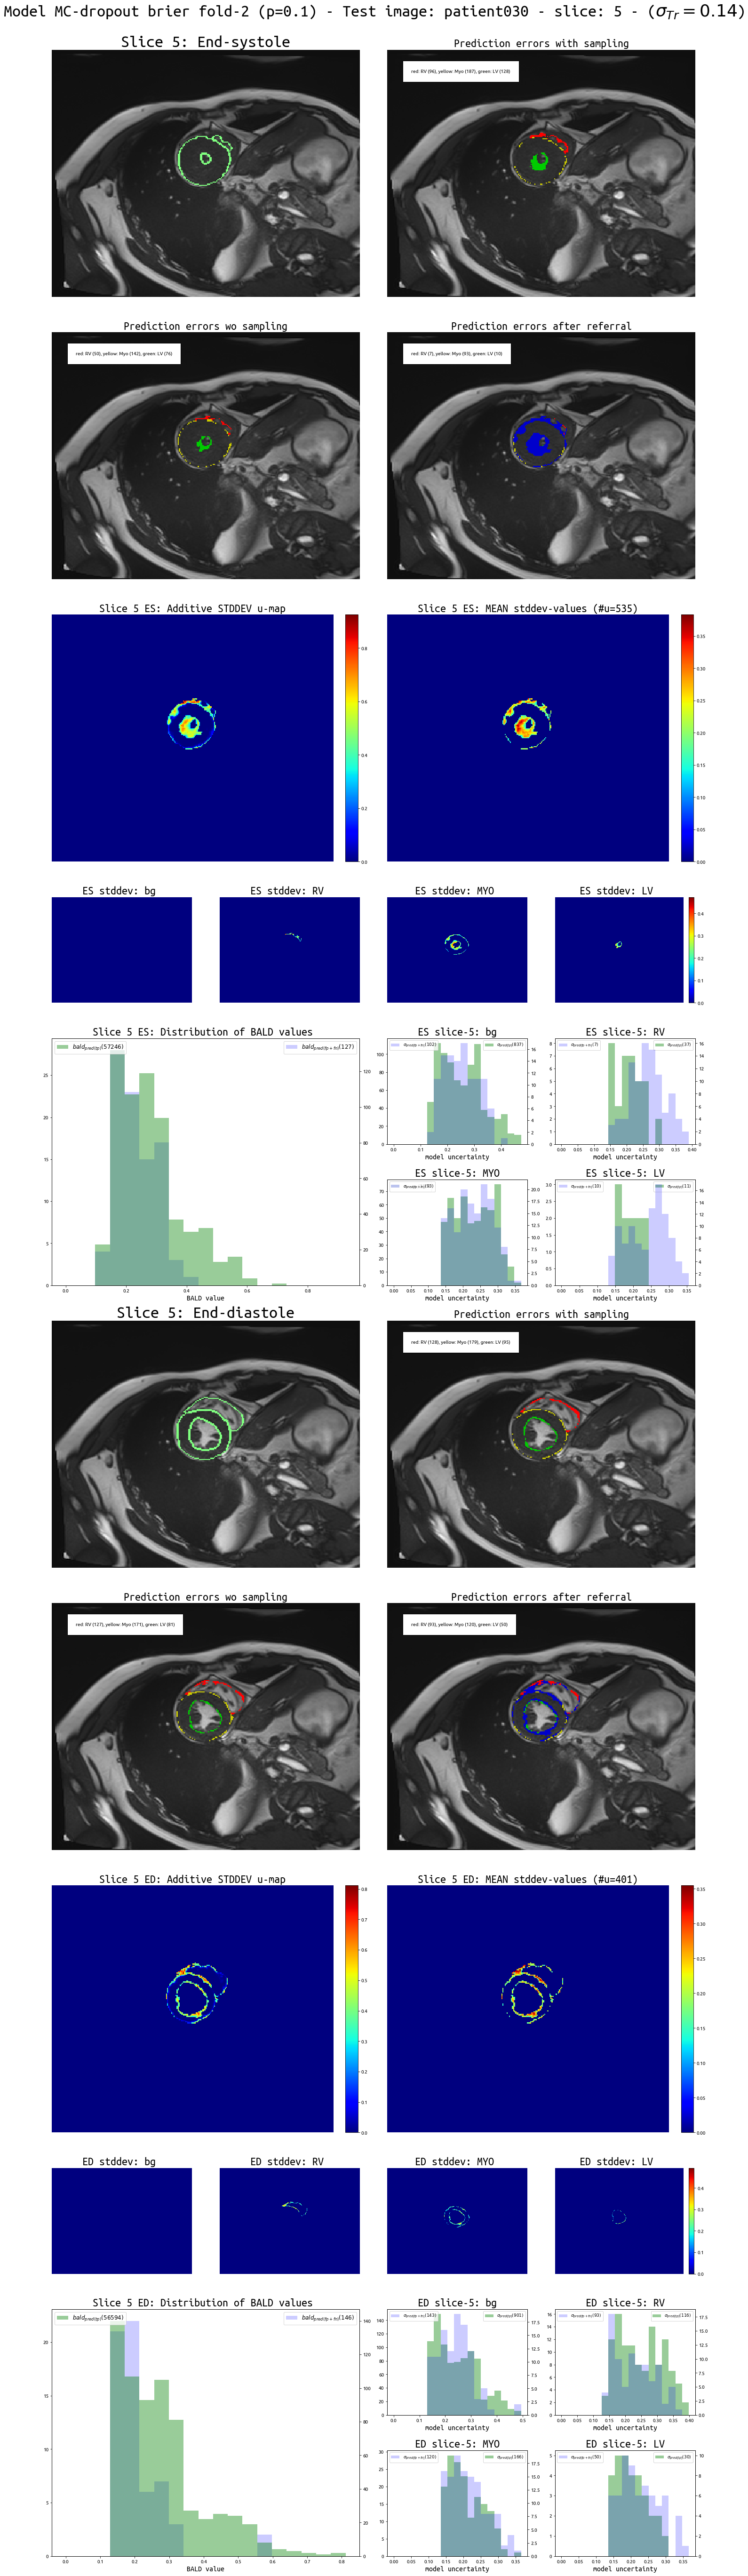

INFO - Ready!


In [90]:
# model_name a) Baseline  b) MC-dropout 0.1

model_name = exper_handler.exper.model_name
errors_only = False  # in case of the BASELINE model we only want the seg-errors
plot_detailed_hists = True
image_range = [9]
if image_range is None:
    image_range = np.arange(len(exper_handler.test_results.image_names))


for image_num in image_range:
    exper_handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                                 info_type="uncertainty",
                                                                 do_save=True, slice_range=[4],
                                                                 std_threshold=0.14, errors_only=errors_only, 
                                                                 do_show=True, use_bald=True,
                                                                 model_name = model_name,
                                                                 plot_detailed_hists=plot_detailed_hists,
                                                                 load_referral=True, ref_positives_only=True)
                                                                 # uncertainty
    print("INFO - Ready!")


U-map max 0.73


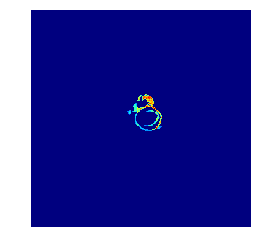

In [56]:
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, config.u_map_dir))
file_name = os.path.join(input_dir, "patient007_filtered_umaps0_14.npz")
data = np.load(file_name)
u_map = data["filtered_umap"]
u_map_es = u_map[0]
img_slice = 9
u_map_slice = u_map_es[:, :, img_slice]
u_map_max = np.max(u_map_slice)
print("U-map max {:.2f}".format(u_map_max))
# u_map_slice[u_map_slice < 0.4] = 0
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
plt.show()
del u_map
del u_map_es
del u_map_slice

(4, 297, 300)
After max  (297, 300)
U-map max 0.73
595


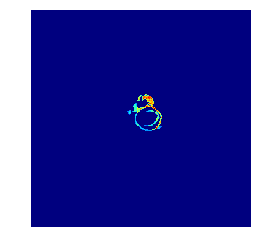

In [58]:
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, config.u_map_dir))
file_name = os.path.join(input_dir, "patient007_filtered_cls_umaps0_14.npz")
data = np.load(file_name)
u_map = data["filtered_cls_umap"]
u_map_es = u_map[:4]
img_slice = 9
u_map_slice = u_map_es[:, :, :, img_slice]
print(u_map_slice.shape)
u_map_slice = np.sum(u_map_slice, axis=0)
print("After max ", u_map_slice.shape)
u_map_max = np.max(u_map_slice)
print("U-map max {:.2f}".format(u_map_max))
print(np.count_nonzero(u_map_slice[u_map_slice >= 0.14]))
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
plt.show()
del u_map
del u_map_es
del u_map_slice

In [133]:
from skimage import data, segmentation
from skimage import exposure
# gb_error_codes = [[], [255, 0, 0], [204, 204, 0], [0, 204, 0]]

img_es = exper_handler.test_results.images[0][0, :, :, 2]
mask = np.zeros_like(img_es)
rv_lbls = exper_handler.test_results.labels[0][1, :, :, 2]
mask[rv_lbls == 1] = 1
myo_lbls = exper_handler.test_results.labels[0][2, :, :, 2]
mask[myo_lbls == 1] = 2
lv_lbls = exper_handler.test_results.labels[0][3, :, :, 2]
mask[lv_lbls == 1] = 3
img_es = exposure.rescale_intensity(img_es)
clean_border = segmentation.clear_border(mask).astype(np.int)
img_lbl = segmentation.mark_boundaries(img_es, clean_border, mode="outer", color=(0, 1, 0), 
                                       background_label=0)
img_lbl = exposure.rescale_intensity(img_lbl, out_range=(0, 1))

(-0.5, 299.5, 261.5, -0.5)

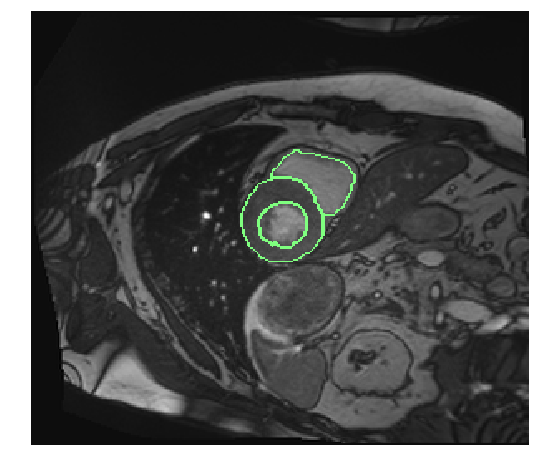

In [135]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=2)
ax1.imshow(img_lbl)
plt.axis('off')

In [63]:
rv_lbls = exper_handler.test_results.labels[0][1, :, :,2]
np.max(rv_lbls)

1.0